In [1]:
import numpy as np
import nengo
from nengo.dists import Choice, Uniform
from nengo.solvers import NoSolver
import matplotlib.pyplot as plt
import seaborn

In [2]:
def make_US_CS_arrays(pairings=3, dt=0.001, seed=0):  # times measured in seconds
    rng = np.random.RandomState(seed=seed)
    pt = 2  # empty time pre-tone
    tt = 3  # tone time
    ps = 4  # empty time pre-shock
    st = 1  # shock time
    wt = 5  # delay time
    at = 5  # active time
    assert at == pt+tt == ps+st, "stimulus times unaligned"
    CS_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    US_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    for i in range(pairings):
        CS_array[int(i*(wt+at)/dt) : int((i*(wt+at)+pt)/dt)] = 0  # nothing
        US_array[int(i*(wt+at)/dt) : int((i*(wt+at)+ps)/dt)] = 0  # nothing
        CS_array[int((i*(wt+at)+pt)/dt) : int((i*(wt+at)+pt+tt)/dt)] = 1  # tone
        US_array[int((i*(wt+at)+ps)/dt) : int((i*(wt+at)+ps+st)/dt)] = 1  # shock
        CS_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
        US_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
    return CS_array, US_array

In [3]:
def go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, seed=0, learning=True,
       oxy_func=lambda t: 0.5, vaso_func=lambda t: 1, musc_CeL_func=lambda t: 0, musc_CeM_func=lambda t: 0, BLA_GABA_func=lambda t: 0.5):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.02
    model.config[nengo.Probe].synapse = 0.02
    with model:
        # Nodes
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        context_inpt = nengo.Node(context_func)
        oxy_inpt = nengo.Node(oxy_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition
        vaso_inpt = nengo.Node(vaso_func)  # default excitation of CeM neurons, causing default freezing
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        BLA_GABA_inpt = nengo.Node(BLA_GABA_func)
        musc_CeL_inpt = nengo.Node(musc_CeL_func)
        musc_CeM_inpt = nengo.Node(musc_CeM_func)
        
        # Ensembles
        # outside amydgala
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        auditory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='auditory cortex')
        sensory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='sensory_cortex')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        hippocampus = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='hippocampus')
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        # central amygdala
        CeL_in = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='CeL_in')  # [tone, shock]
        CeL_out = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_out')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        error_CeL_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_pos')
        error_CeL_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_neg')
        # basolateral amygdala
        BLA = nengo.Ensemble(600, 3, label='BA')  # [tone, shock, context]
        error_tone = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_tone')
        error_context_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_pos')
        error_context_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_neg')
        BLA_GABA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='BLA_GABA')
        
        # Connections
        # inputs and outputs
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(tone_inpt, auditory_cortex)
        nengo.Connection(shock_inpt, sensory_cortex)
        nengo.Connection(context_inpt, hippocampus)
        nengo.Connection(oxy_inpt, CeL_out)
        nengo.Connection(vaso_inpt, CeM)
        nengo.Connection(motor_inpt, PAG)
        # central amygdala
        thal_CeL = nengo.Connection(thalamus, CeL_in[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(3e-6*learning))  # learning tone-fear
        nengo.Connection(spinal_cord, CeL_in[1])
        nengo.Connection(CeL_in[0], CeL_out, transform=-1)  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_out, CeM, transform=-1)  # inhibit default freezing
        nengo.Connection(CeL_in, error_CeL_pos, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(CeL_in, error_CeL_neg, function=lambda x: x[0]-x[1])  # error signal, tone - shock
        nengo.Connection(error_CeL_pos, thal_CeL.learning_rule, transform=-1)
        nengo.Connection(error_CeL_neg, thal_CeL.learning_rule, transform=0.2)
        nengo.Connection(CeM, PAG, transform=-1)
        # basolateral amygdala
        cortex_BLA = nengo.Connection(auditory_cortex, BLA[0], solver=NoSolver(d_cortex_BLA), learning_rule_type=nengo.PES(3e-6*learning))  # learning tone-fear
        nengo.Connection(sensory_cortex, BLA[1])
        hippo_BLA = nengo.Connection(hippocampus.neurons, BLA[2], transform=d_hippo_BLA.T, learning_rule_type=nengo.PES(3e-6*learning))  # learning context-fear/extinct
        nengo.Connection(BLA, error_tone, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(BLA, error_context_pos, function=lambda x: x[1]-x[2])  # error = shock - tone (reversed below)
        nengo.Connection(BLA, error_context_neg, function=lambda x: x[0]-x[1])  # error = tone - shock
        nengo.Connection(error_tone, cortex_BLA.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(error_context_pos, hippo_BLA.learning_rule, transform=-1)  # context-fear association, error = tone - shock
        nengo.Connection(error_context_neg, hippo_BLA.learning_rule, transform=0.2)  # context-extinct association, smaller learning rate than context-fear
        nengo.Connection(BLA_GABA, BLA[0], transform=-0.75)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, BLA[1], transform=-0.75)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, BLA[2], transform=-0.75)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, error_tone, transform=-0.5)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, error_context_pos, transform=-0.5)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, error_context_neg, transform=-0.5)  # GABAergic inhibition
        nengo.Connection(BLA, CeM, function=lambda x: 0.25*x[0]+0.75*x[2]) # combination of tone and context response
        # pharmacology
        nengo.Connection(BLA_GABA_inpt, BLA_GABA)
        nengo.Connection(musc_CeL_inpt, CeL_in.neurons, transform=np.ones((CeL_in.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, CeL_out.neurons, transform=np.ones((CeL_out.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, error_CeL_pos.neurons, transform=np.ones((error_CeL_pos.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, error_CeL_neg.neurons, transform=np.ones((error_CeL_neg.n_neurons, 1)))
        nengo.Connection(musc_CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        
        # Probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_auditory_cortex = nengo.Probe(auditory_cortex)
        p_sensory_cortex = nengo.Probe(sensory_cortex)
        p_CeL_in = nengo.Probe(CeL_in)  
        p_CeL_out = nengo.Probe(CeL_out)
        p_CeM = nengo.Probe(CeM)
        p_BLA = nengo.Probe(BLA)
        p_BLA_GABA = nengo.Probe(BLA_GABA)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL_pos = nengo.Probe(error_CeL_pos)
        p_error_CeL_neg = nengo.Probe(error_CeL_neg)
        p_error_tone = nengo.Probe(error_tone)
        p_error_context_pos = nengo.Probe(error_context_pos)
        p_error_context_neg = nengo.Probe(error_context_neg)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        p_cortex_BLA = nengo.Probe(cortex_BLA, 'weights', synapse=None)
        p_hippo_BLA = nengo.Probe(hippo_BLA, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, progress_bar=False, seed=seed)
    with sim:
        sim.run(t, progress_bar=True)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        auditory_cortex = sim.data[p_auditory_cortex],
        sensory_cortex = sim.data[p_sensory_cortex],
        CeL_in = sim.data[p_CeL_in],
        CeL_out = sim.data[p_CeL_out],
        BLA = sim.data[p_BLA],
        BLA_GABA = sim.data[p_BLA_GABA],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL_pos = sim.data[p_error_CeL_pos],
        error_CeL_neg = sim.data[p_error_CeL_neg],
        error_tone = sim.data[p_error_tone],
        error_context_pos = sim.data[p_error_context_pos],
        error_context_neg = sim.data[p_error_context_neg],
        thal_CeL = sim.data[p_thal_CeL][-1].T,
        cortex_BLA = sim.data[p_cortex_BLA][-1].T,
        hippo_BLA = sim.data[p_hippo_BLA][-1].T,
    )

# Simulations

## Pre-training

## Control

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

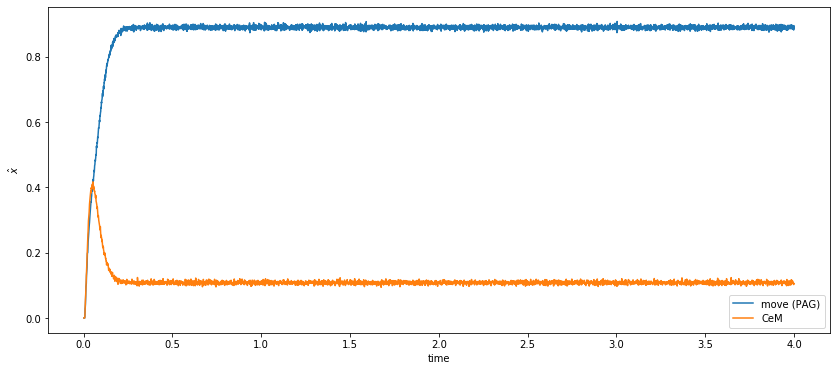

(0.8904131647948459,
 0.8905613744781535,
 0.8906708202308794,
 0.8905928920457942)

In [8]:
def pre_control(plot=True):

    t = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    
    data = go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)
    
    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()
        
    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

pre_control()

### Activation of CeM induces spontaneous freezing
Optogenetically activating CeM neurons elicits freezing (Ciocchi et al., 2010). Since CeM expresses vasopressin receptors (Huber et al. 2015), application of this neuropeptide should have a similar effect (look for citation).

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

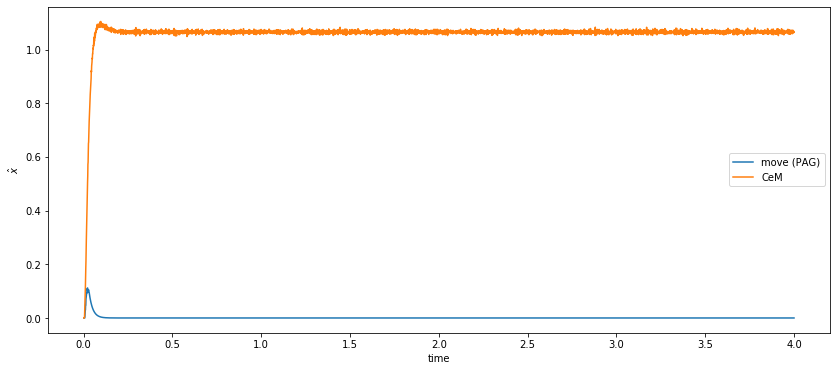

(6.521671681768104e-08,
 1.2578673264680904e-29,
 2.4261114146841372e-51,
 4.679362022215583e-73)

In [9]:
def pre_muscimol_CeM(plot=True):

    t = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    vaso_func = lambda t: 2

    data = go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, vaso_func=vaso_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

pre_muscimol_CeM()

### Inctivation of CeL induces spontaneous freezing
GABA_A receptor agonist (muscimol-bodipy (BPY)) applied to CeL alone induced spontaneous freezing (Ciocchi et al, 2010)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

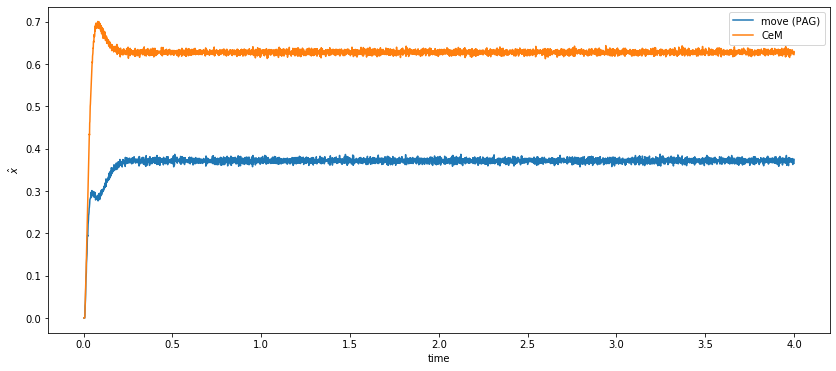

(0.3715098408116571,
 0.3716087552502164,
 0.37170871209090833,
 0.3716398348300022)

In [11]:
def pre_muscimol_CeL(plot=True):

    t = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    musc_CeL_func = lambda t: -1

    data = go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_CeL_func=musc_CeL_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

pre_muscimol_CeL()

## During training experiments

### Control

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

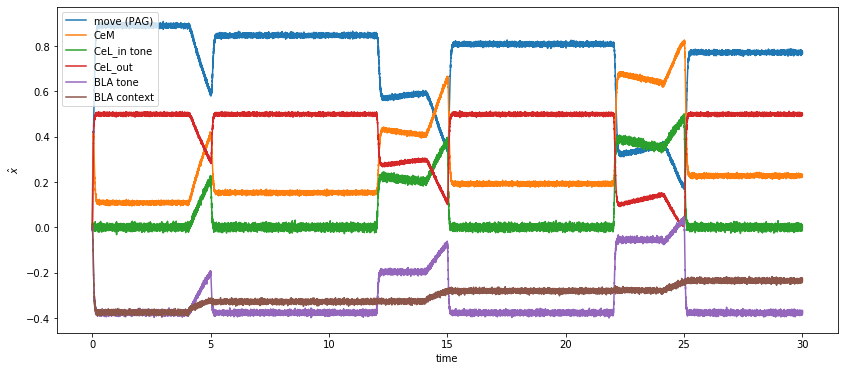

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

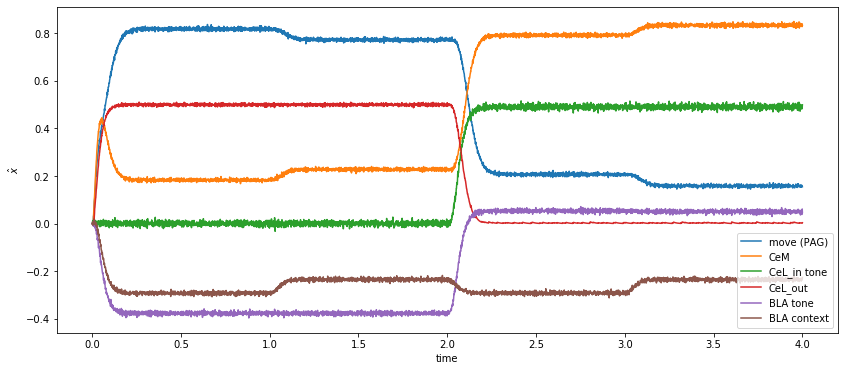

(0.8175044552313665,
 0.7718634739474597,
 0.20691312990102295,
 0.15824196840628985)

In [12]:
def condition_control(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

condition_control()

### Inactivation of CeL during training impairs fear conditioning
Muscimol (Ciocchi et al., 2010)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

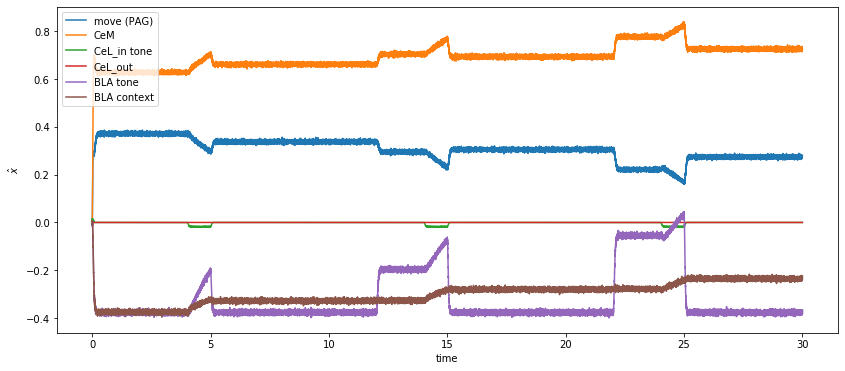

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

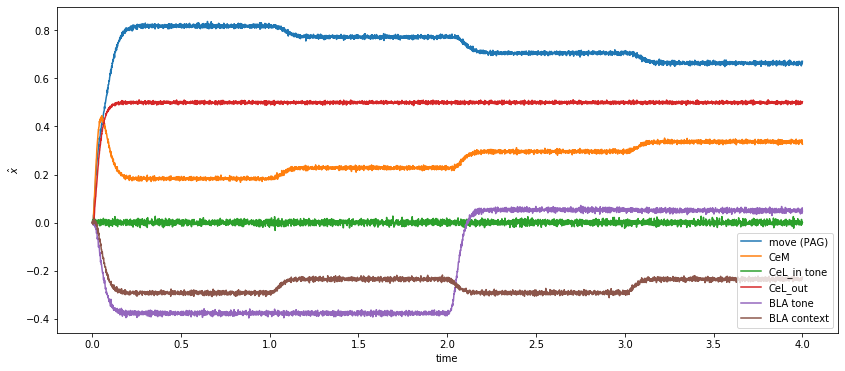

(0.8175044552313665,
 0.7718634739474597,
 0.7050631232819681,
 0.6633075463196051)

In [18]:
def muscimol_CeL_condition(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    musc_CeL_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_CeL_func=musc_CeL_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

muscimol_CeL_condition()

### Applying oxytocin to CeL during conditioning does not affect learning
Viviani et al., 2011

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

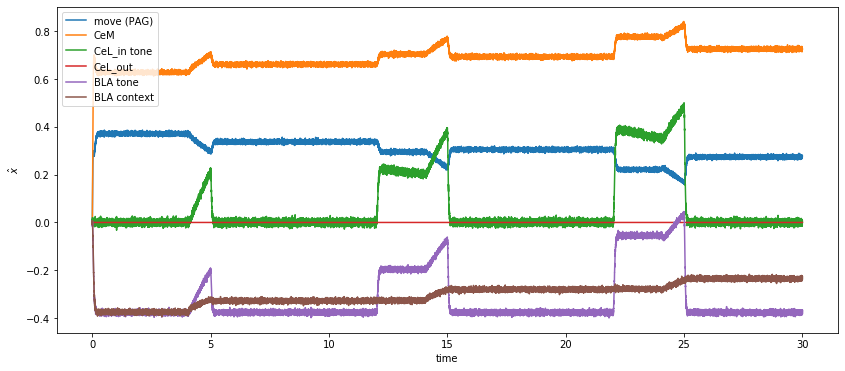

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

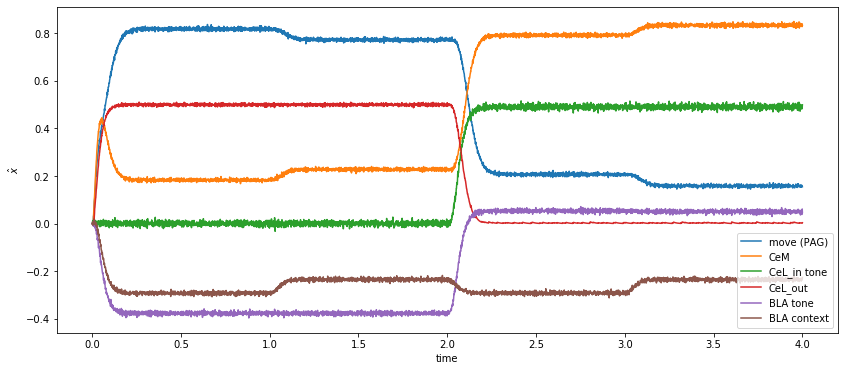

(0.8175044552313665,
 0.7718634739474597,
 0.20691312990102295,
 0.15824196840628985)

In [19]:
def oxy_CeL_condition(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    oxy_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, oxy_func=oxy_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

oxy_CeL_condition()

### Inactivation of GABAergic interneurons in BLA facilitates fear conditoning
Dopamine and Norepinephrine are natural neuromodulators of inhibition in BLA, and their presence is implicated in the aquisition of conditioned fear (Bush et al., 2010; Greba et al., 2001; Guarraci et al., 1999; Nader and LeDoux, 1999)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

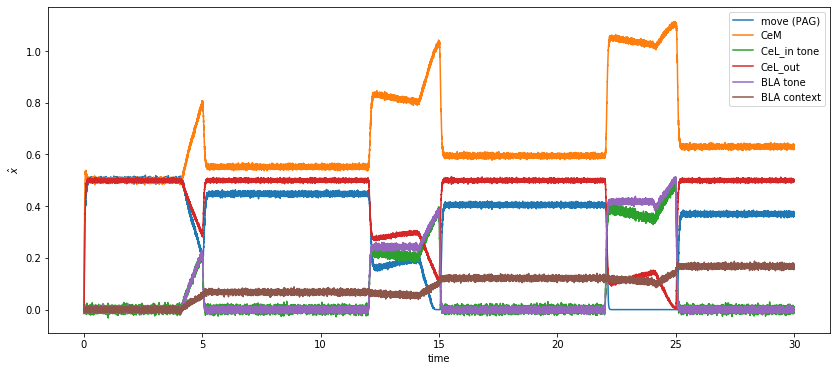

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

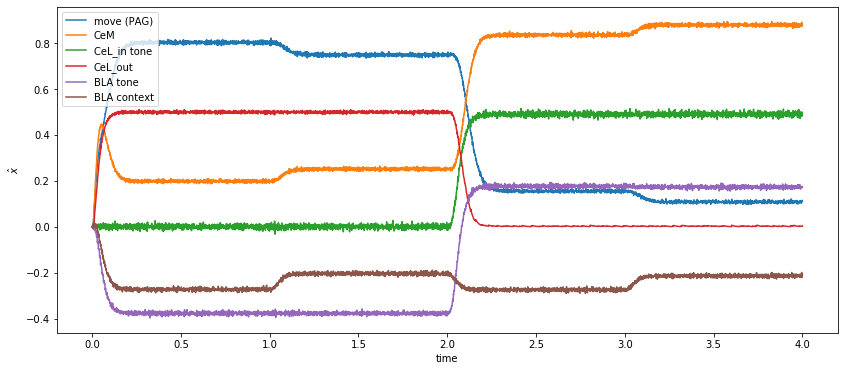

(0.8024208132792221,
 0.7487829093084519,
 0.15595755741064996,
 0.10807861165139858)

In [20]:
def DA_BLA_condition(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_GABA_func = lambda t: 0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_GABA_func=BLA_GABA_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

DA_BLA_condition()

### Activation of GABAergic interneurons in BLA impairs fear conditoning
Serotonin is a natural neuromodulators of inhibition in BLA, and its presence is implicated in constraining synaptic plasticity in LA (Shumyatsky et al., 2002). Applying muscimol to BLA mimics these dampening effects and reduces fear conditioning (Muller et al. 1997). 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

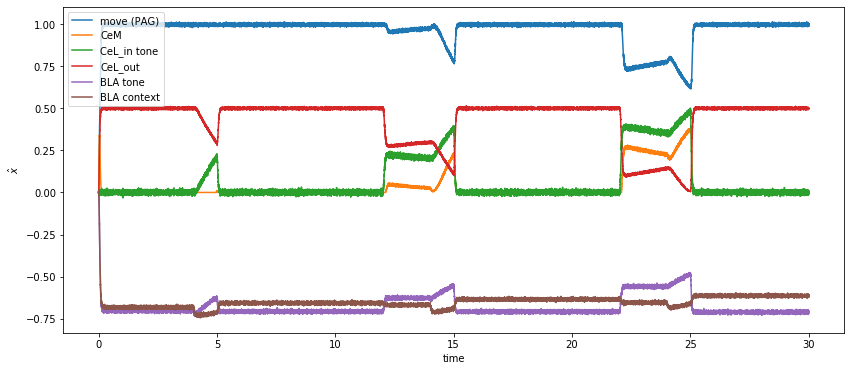

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

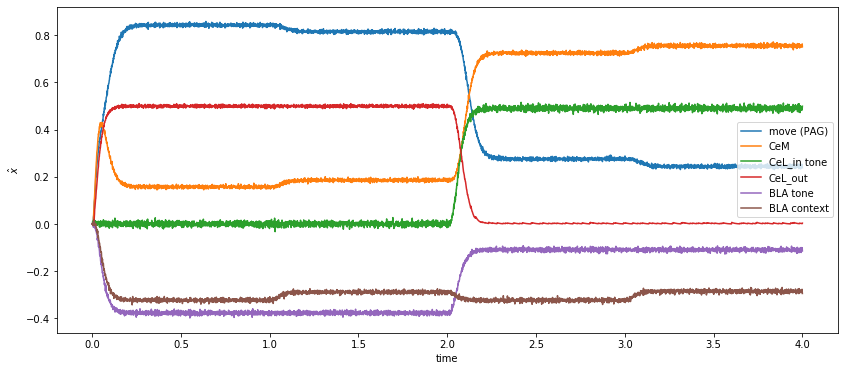

(0.842670545413466, 0.814718045458093, 0.27574422766477674, 0.2438378673558812)

In [21]:
def muscimol_BLA_condition(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_GABA_func = lambda t: 1.0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_GABA_func=BLA_GABA_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

muscimol_BLA_condition()

## Extinction

### control

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

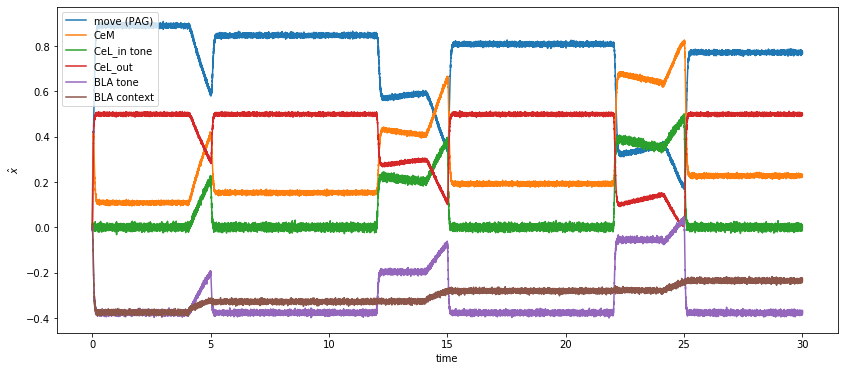

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


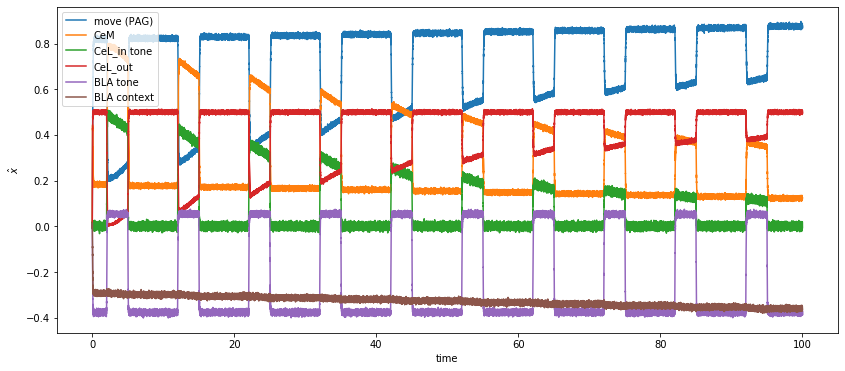

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

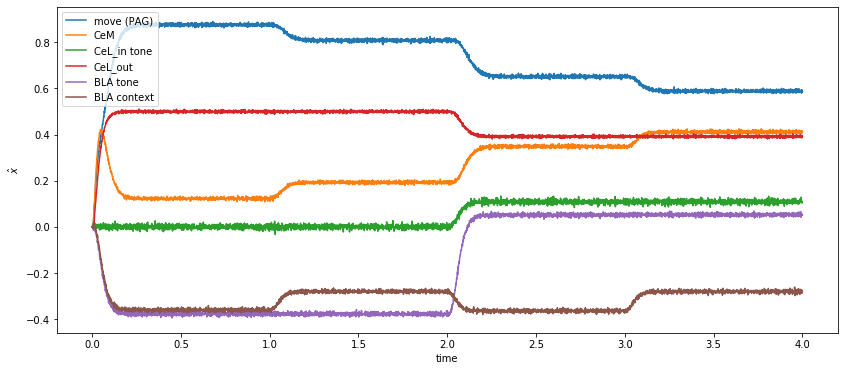

(0.8750590086576878, 0.8075941367278795, 0.651169670700199, 0.5881553759344478)

In [22]:
def extinction_control(plot=True):

    t_condition = 30
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

extinction_control()

### Inactivation of BLA impairs extinction
Sierra-Mercado et al., 2011

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

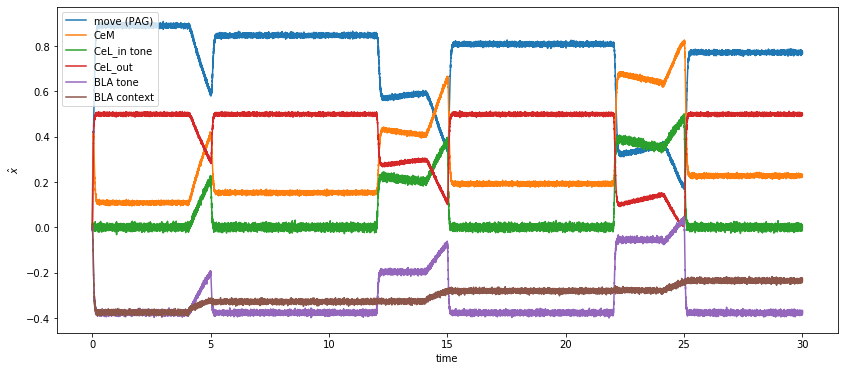

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

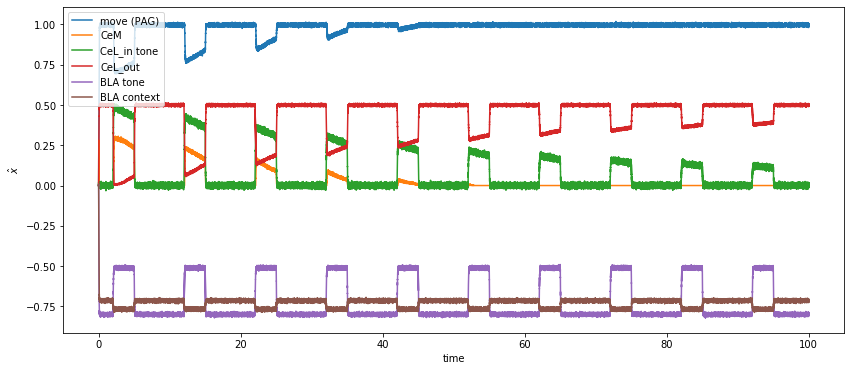

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

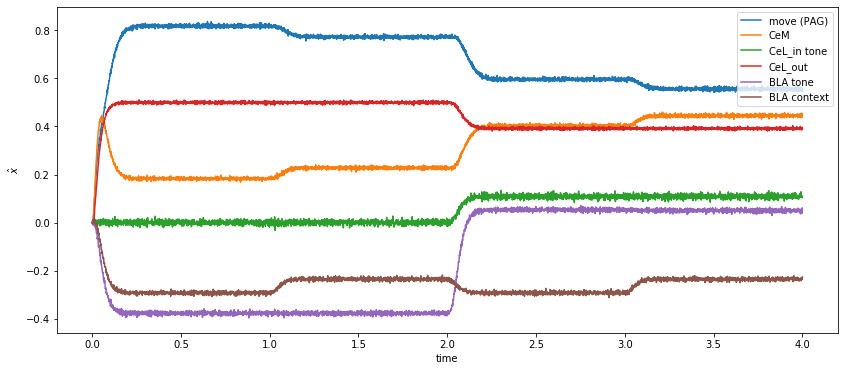

(0.8175044552313665,
 0.7718634739474597,
 0.5958267279519464,
 0.5559111536015766)

In [27]:
def muscimol_BLA_extinction(plot=True):

    t_condition = 30
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]
    BLA_GABA_func = lambda t: 1

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_GABA_func=BLA_GABA_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

muscimol_BLA_extinction()

## Post-training

### Applying oxytocin during testing reduces conditioned fear
Viviani et al. 2011

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

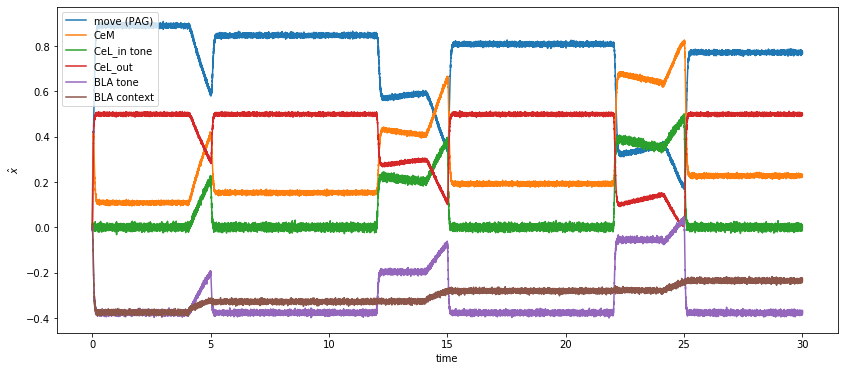

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

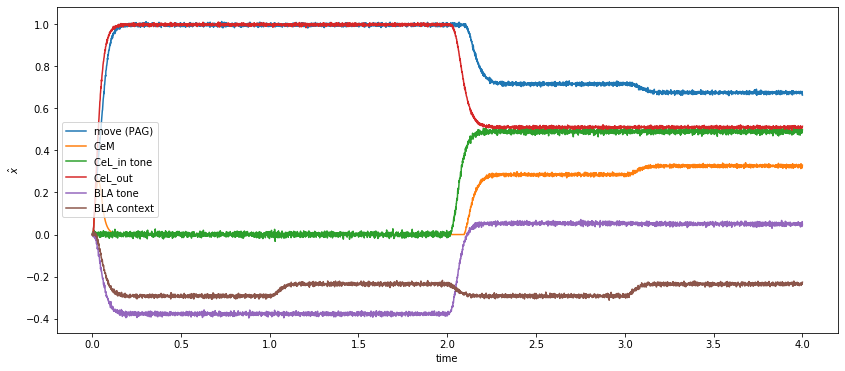

(0.996402584260394, 0.9964013525265744, 0.7164741674062006, 0.6745138087114951)

In [26]:
def condition_oxy_CeL(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    oxy_func = lambda t: 1
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, oxy_func=oxy_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

condition_oxy_CeL()

### Inactivating BLA during testing reduces conditioned fear
Muller et al., 1997

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

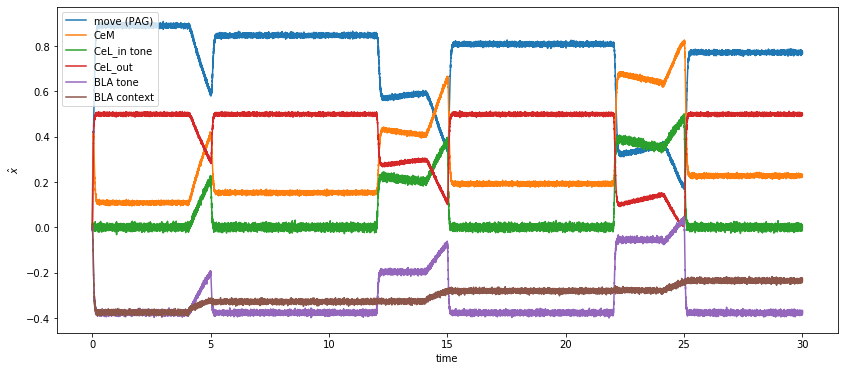

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

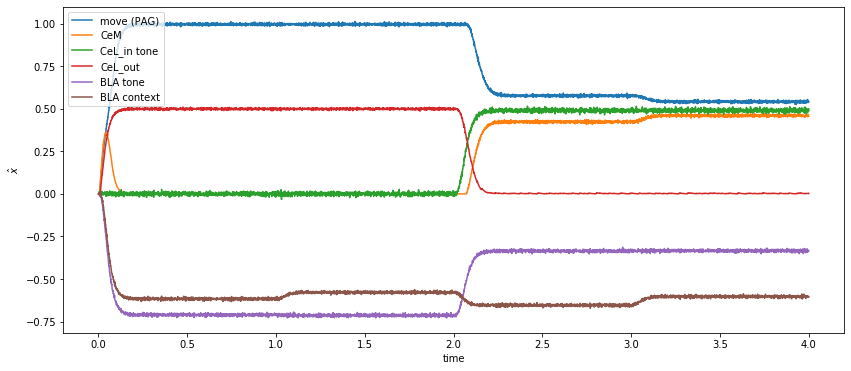

(0.9963646874559561,
 0.9964137466168733,
 0.5769884323486054,
 0.5413992291482149)

In [25]:
def condition_muscimol_BLA(plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    BLA_GABA_func = lambda t: 1.0
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_GABA_func=BLA_GABA_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data['times'], data['PAG'], label='move (PAG)')
        ax.plot(data['times'], data['CeM'], label='CeM')
        ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
        ax.plot(data['times'], data['CeL_out'], label='CeL_out')
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone')
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context')
        ax.set(xlabel='time', ylabel=r'$\hat{x}$')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

condition_muscimol_BLA()

# Data Collection

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

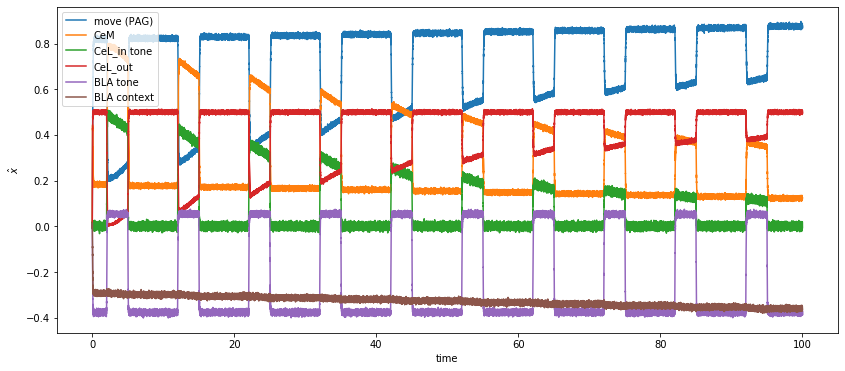

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

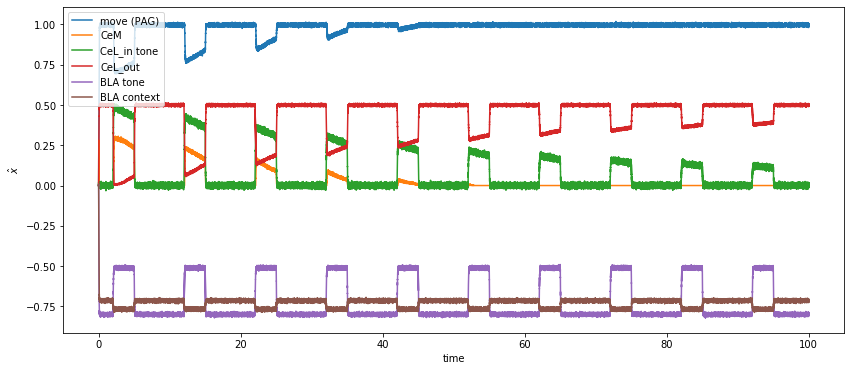

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

NameError: name 'extinction_oxy' is not defined

In [29]:
nrmses = dict()
nrmses['pre_control'] = []
nrmses['pre_muscimol_CeM'] = []
nrmses['pre_muscimol_CeL'] = []
nrmses['condition_control'] = []
nrmses['muscimol_CeL_condition'] = []
nrmses['oxy_CeL_condition'] = []
nrmses['DA_BLA_condition'] = []
nrmses['muscimol_BLA_condition'] = []
nrmses['extinction_control'] = []
nrmses['muscimol_BLA_extinction'] = []
nrmses['condition_oxy'] = []
nrmses['condition_muscimol_BLA'] = []

n_trials = 2
for n in range(n_trials):
    # 0=neither, 1=context, 2=tone, 3=both
    nrmses['pre_control'].append(pre_control(plot=False)[2])
    nrmses['pre_muscimol_CeM'].append(pre_muscimol_CeM(plot=False)[2])
    nrmses['pre_muscimol_CeL'].append(pre_muscimol_CeL(plot=False)[2])
    nrmses['condition_control'].append(condition_control(plot=False)[2])
    nrmses['muscimol_CeL_condition'].append(muscimol_CeL_condition(plot=False)[2])
    nrmses['oxy_CeL_condition'].append(oxy_CeL_condition(plot=False)[2])
    nrmses['DA_BLA_condition'].append(DA_BLA_condition(plot=False)[2])
    nrmses['muscimol_BLA_condition'].append(muscimol_BLA_condition(plot=False)[2])
    nrmses['extinction_control'].append(extinction_control(plot=False)[2])
    nrmses['muscimol_BLA_extinction'].append(muscimol_BLA_extinction(plot=False)[2])
    nrmses['condition_oxy'].append(extinction_oxy(plot=False)[2])
    nrmses['condition_muscimol_BLA'].append(extinction_muscimol_BLA(plot=False)[2])